### Imports

In [154]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### EDA

#### Exploring Data

In [ ]:
train_df = pd.read_csv("data/train.csv")

In [156]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
756,757,0,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C


aim of EDA is to get:
- number of rows
- number of columns
- what data type has been used 
- which column has how many non null values 
- find the total number of entries 
- can also the shape of your df using df.shape

In [157]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- in the training data, first thing i want to check what exactly is the proportion of people surviving to ppl dying 
- this is to see how biased our training data is because if number of survivors are significantly higher than number of ppl dying then the model will more likely predict someone to 1 than to 0 

In [158]:
alive = train_df['Survived'].sum() # works because of 0 and 1, sum of all 1's is the total ppl survived
print("alive:", alive) 

# .count() will give number of non null values in each column of the survived data frame
# train_df[train_df['Survived']==1].count()
dead = train_df.shape[0] - train_df[train_df['Survived']==1].shape[0]
print("dead:",dead)
print('ratio of dead to alive:', dead/alive) # for every 100 survivors, there were at least 160 dead 

alive: 342
dead: 549
ratio of dead to alive: 1.605263157894737


- find how many null values you have in your dataset in each feature (column)

In [159]:
train_df.isna().sum()
# we see a lot of null values in age and cabin 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Finding Patterns 

now, there are ways you can deal with null values:
- replace the null values with the median values 
- drop the rows which contain any null value (but don't do this unless you're absolutely sure that it doesn't impact predictions)

so, before we do any dropping or filling, let's check how the varibales impact each other using a heatmap, our main concern would be how specifically are they related with survival, can also use pairplot i believe but let's stick with heatmap for now

the purpose of doing this is to find hidden correlations or patterns within the data that may not be explicit

In [160]:
# before we plot a heatmap, we first eliminate non-numeric columns since they can't have a corrleation coefficient
# we will use bar charts to see later 
train_df_mod = train_df.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])
train_df_mod.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


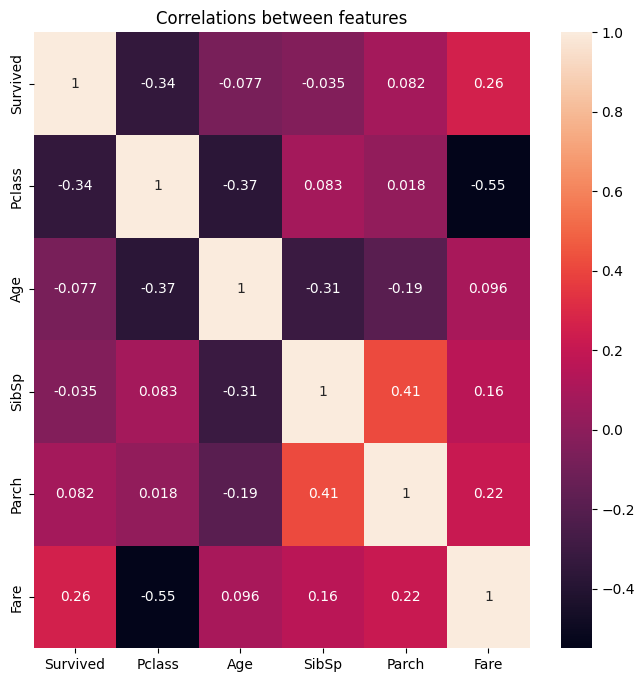

In [161]:
plt.figure(figsize=(8,8), dpi=100) # you first create the fig, then give a title
plt.title("Correlations between features")

# passenger id will also have no impact
sns.heatmap(train_df_mod.drop(columns =['PassengerId']).corr(), annot=True) # annot=True gives the correlation coefficient 
plt.show()

- we don't really see any meaningful correlation of survival with the features used 
- but one thing is for sure that passenger class and fare will have a decent inverse relation because the more you pay, you get the higher class (lower numbered)
- fare: 1st class > 2nd class > 3rd class
- even age had almost no correlation with survival, all die alike (0.07)
---
- now, let's see how the columns we previously dropped affect survival
- those columns are: **name, sex, ticket, cabin and embarked**
- intuitively, name, ticket number and cabin seem to have very less chance of affecting someone's survival 
- but we will see it later 

- now, let's see how sex and embarking destination affect survivor numbers 
- i mean, did ppl of particular age survive more or died more
- or if more ppl from southampton died as compared to other boarding destinations
- we can also filter out number of survivors based on boarding stations and sex so let's just start with that

#### Correlation between Sex and Survival 

In [162]:
survival_sex = train_df[['Survived', 'Sex']]
survival_sex.shape

(891, 2)

In [163]:
survival_sex.groupby(['Survived', 'Sex']).size()
# when you run this, you get a pandas series with a multi level index, can check type using type()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64

in our training data:
- 81 females died, 468 males died 
- 233 females lived, 109 males lived 

- more number of males died and lesser number of males lived
- we figured this out using groupby, no need of manual counting using filter like above you did

- resulting value is what we get by using size()

use of `reset_index`:
- flattens the above multi level index of pandas series into regular rows and columns
- it names the resulting values column to count (since above we don't have any column name for resulting values)

- by default, size() gives an unnamed Series, so reset_index(name='count') says: “Hey, when you turn this Series into a column, call it 'count'.”
- you can give any name instead of 'count' like `.reset_index(name='TotalPassengers')
`


In [164]:

grouped = survival_sex.groupby(['Survived', 'Sex']).size().reset_index(name='count')
grouped.head()

,Survived,Sex,count
0,0,female,81
1,0,male,468
2,1,female,233
3,1,male,109


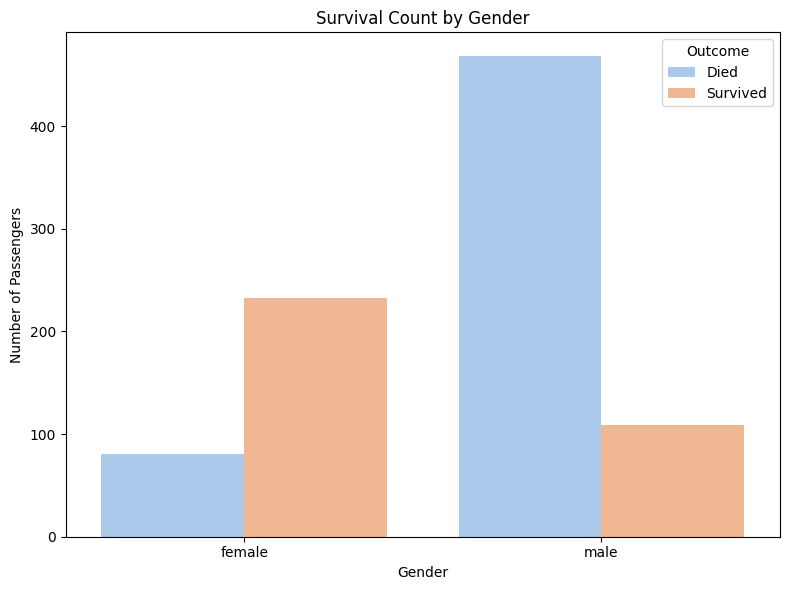

In [165]:
grouped['Survived'] = grouped['Survived'].map({0:'Died', 1:'Survived'})
# .map() reads all row values for 'Survived' column and changes them accordingly

# plot now 
plt.figure(figsize=(8,6), dpi=100)
sns.barplot(data=grouped, x='Sex', y='count', hue='Survived', palette='pastel')
# hue='Survived' tells seaborn to split x axis values into two groups: Survived vs Died

plt.title("Survival Count by Gender")
plt.ylabel("Number of Passengers")
plt.xlabel("Gender")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

comparing the two blue and orange bars side by side, we see
- more number of males died 
- more number of females survived

for fun:
- you can also pivot the data to have a new data frame in different orinetation 
- pivot means reshaping the dataframe so that sex becomes the index
- and survived becomes the columns - that is what we mean by 'pivoting on' the survived column
- the value that fills the cell comes from count

In [166]:
# Pivot so 'Sex' is the index, 'Survived' becomes columns, and 'count' are values
pivot_df = grouped.pivot(index='Sex', columns='Survived', values='count')
pivot_df.columns.name = None # removed Survived in the top left of first coulumn, which pandas keep by default (name of the column on which we pivotted on)
pivot_df

,Died,Survived
Sex,,
female,81,233
male,468,109


#### Correlation between Boarding Port and Survival

now similarly, let's see the bar graph for different boarding port

question answered: how many number of ppl survived/died from each boarding port? 

In [167]:
train_df.shape

(891, 12)

In [168]:
train_df['Embarked'].isna().sum()

np.int64(2)

In [169]:
survival_dest = train_df[['Survived', 'Embarked']]
# this is a pandas series, we use reset index below to convert into a dataframe

In [170]:
grouped = survival_dest.groupby(['Survived', 'Embarked']).size().reset_index(name='count')
grouped.head()
grouped['count'].sum()

np.int64(889)

here, we get 889 relations only between survived and embarked

leaving two because two values of embarked are null values 

if you want to see which two exact rows have that null values, do this

In [171]:
train_df[train_df['Embarked'].isna()]
# can see that we have two female passengers whose boarding port is unknown

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [172]:
grouped

,Survived,Embarked,count
0,0,C,75
1,0,Q,47
2,0,S,427
3,1,C,93
4,1,Q,30
5,1,S,217


In [173]:
# make it more readable
grouped['Survived'] = grouped['Survived'].map({0:"Died", 1:"Survived"})
grouped['Embarked'] = grouped['Embarked'].map({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})
grouped

,Survived,Embarked,count
0,Died,Cherbourg,75
1,Died,Queenstown,47
2,Died,Southampton,427
3,Survived,Cherbourg,93
4,Survived,Queenstown,30
5,Survived,Southampton,217


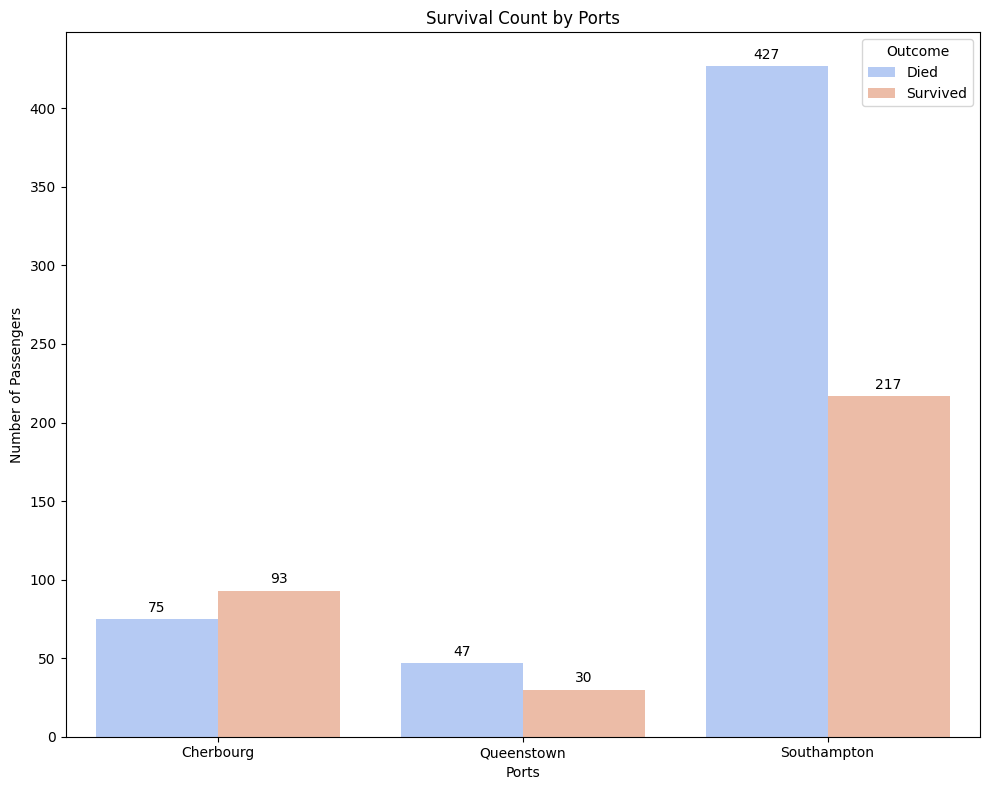

In [174]:
# plot now
plt.figure(figsize=(10,8), dpi=100)

# without annotation: sns.barplot(data=grouped, x='Embarked', y='count', hue='Survived', palette='coolwarm')

ax = sns.barplot(data=grouped, x='Embarked', y='count', hue='Survived', palette='coolwarm')

# Annotate each bar with the value
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title("Survival Count by Ports")
plt.ylabel("Number of Passengers")
plt.xlabel("Ports")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

we can clearly see that most ppl survived and died from southampton but that may also be because the number of passengers may be much more from southapmton to explain this 

about the code:
- ax.containers contains the individual bar groups.
- ax.bar_label() adds the value label on each bar.
- fmt='%d' ensures labels are shown as whole numbers.
- label_type='edge' puts the label just above the bar.

In [175]:
# count number of passsengers from each port 
ports  = train_df['Embarked']
ports.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [176]:
# you use value_counts() for counting unique values
ports.value_counts()
# this is Series 

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

this clearly shows that ppl from southampton are way more than cherbourg or queenstown which explains why they died/survived more

#### Fun Donut Chart

we use this donut chart to display number of passengers from each port 

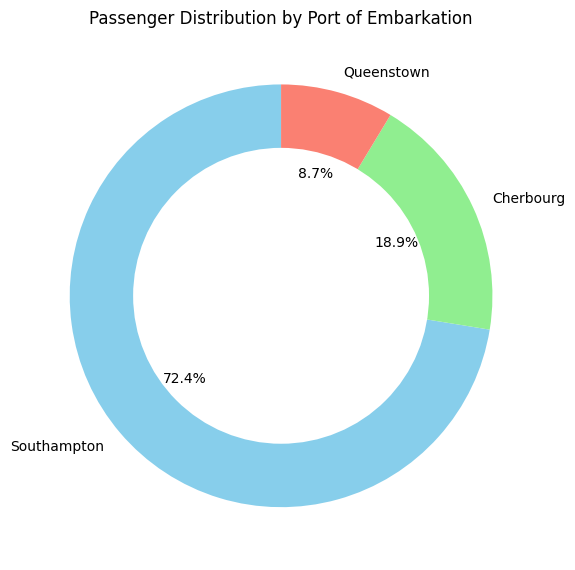

In [177]:
port_counts = train_df['Embarked'].value_counts() # a series
port_labels = port_counts.index.map({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})

# create donut chart 
plt.figure(figsize=(6,6))
plt.pie(port_counts, labels=port_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'salmon'])

# Draw white circle in center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Passenger Distribution by Port of Embarkation")
plt.tight_layout()
plt.show()

### Feature Engineering

`aim:`
- extract deck from cabin 
- extract title from names which can represent role + gender + societal status
- extract family size 

##### Extract Decks

In [178]:
# before we do any extraction, we check 
train_df['Cabin'].isna().sum()

np.int64(687)

we have 687/891 null values which is a lot but the model can still train on the remaining ones to get a prediction.

the reason we extract deck from cabin is because richer people would be on the higher deck (higher class, more fare price) so they would be closer to lifeboats and have a higher chance of surviving as compared to someone who is on a lower deck because they would be closer to water.

In [179]:
# first fill the null decks with some 'U' (for unknown)
train_df['Cabin']=train_df['Cabin'].fillna('U')

# extract deck 
train_df['Deck']=train_df['Cabin'].astype(str).str[0]

In [180]:
train_df["Deck"].value_counts().sort_index()

Deck
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
U    687
Name: count, dtype: int64

ignore U

we see that out of all the known decks, most number of middle-class passengers would be from B to E, explaining their higher numbers 

top and bottom decks would have less people as in real life so they do here 

In [181]:
# find number of people on each deck 
# using groupby instead of sort index or value counts

# step 1: see the number of categories and their counts using groupby  
grouped = train_df.groupby(['Deck']).size().reset_index(name='pax/deck')
grouped

,Deck,pax/deck
0,A,15
1,B,47
2,C,59
3,D,33
4,E,32
5,F,13
6,G,4
7,T,1
8,U,687


In [182]:
# step 2: check survival rate of each category 
# we need to group by deck and calculate mean of 'Survived' column
train_df.groupby('Deck')['Survived'].mean()

Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

We can see that decks B to F have more than 50% rate of survival!

| Deck | Survived |
| ---- | -------- |
| A    | 1        |
| A    | 0        |
| A    | 1        |
| B    | 0        |
| B    | 0        |
- For Deck A: Survival rate = (1 + 0 + 1) / 3 = 0.67
- For Deck B: Survival rate = (0 + 0) / 2 = 0.0

This is what the code above does automatically

- visually showing the survival rate of each deck

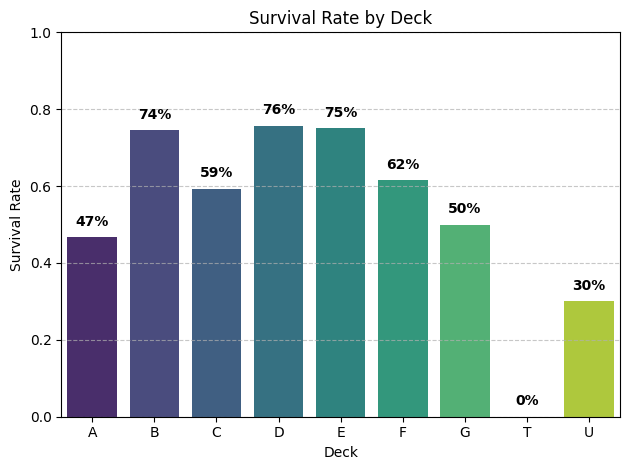

In [183]:
# Prepare data
deck_survival = train_df.groupby('Deck')['Survived'].mean().reset_index()

# Bar plot
sns.barplot(data=deck_survival, x='Deck', y='Survived', hue='Deck', palette='viridis')
plt.title('Survival Rate by Deck')
plt.ylim(0, 1)
plt.ylabel('Survival Rate')
plt.xlabel('Deck')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate exact survival rates
for i, row in deck_survival.iterrows():
    plt.text(i, row['Survived'] + 0.03, f"{row['Survived']:.0%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("deck_survival.png", dpi=300)
plt.show()

##### Extract Titles

- .astype() str converts each value in column to string by calling str() on each value
- .str is used to access pandas string methods (like `.str.extract()`, `.str.contains()`, etc). Doesn't convert types, expects the column to already be strings or convertible. 

In [184]:
# extract title using regex 
train_df['Title'] = train_df['Name'].str.extract(r',\s*([^\.]*)\s*\.')

In [185]:
# step 1: see the number of categories and their counts using groupby  

# what all titles we have? train_df['Title'].unique() {gets you a numpy array}
# but to also see their counts, use group by 
train_df.groupby('Title').size().reset_index(name='Count')

,Title,Count
0,Capt,1
1,Col,2
2,Don,1
3,Dr,7
4,Jonkheer,1
5,Lady,1
6,Major,2
7,Master,40
8,Miss,182
9,Mlle,2


In [186]:
# Replace rare/strange titles with 'Other' or combine similar ones
train_df["Title"] = train_df["Title"].replace({
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Dr': 'Other', 'Major': 'Other', 'Col': 'Other',
    'Lady': 'Miss', 'Sir': 'Mr', 'Capt': 'Other',
    'the Countess': 'Other', 'Don': 'Other', 'Jonkheer': 'Other', 'Rev': 'Other'
})

In [187]:
train_df.groupby('Title').size().reset_index(name='Count')

,Title,Count
0,Master,40
1,Miss,186
2,Mr,518
3,Mrs,126
4,Other,21


the above table easily gives the composition of gender + social status 

In [188]:
# step 2: check survival rate of each category 

# now if we want to check survival rate based on this
train_df.groupby('Title')['Survived'].mean()

Title
Master    0.575000
Miss      0.704301
Mr        0.158301
Mrs       0.793651
Other     0.285714
Name: Survived, dtype: float64

amazing insight!

- we can easily see that married woman have almost 80% chance of survival!!
- similarly, unmarried woman and kids have more than 50% chance of survival
- we can see that males have very less survival chance 

∴ 'Name', which we earlier discarded as 'useless' turns `very very useful` when extracted the titles 

`charts for survival rate by title`

we've both:
- number of people who had this title
- percentage of people per title who survived

∴ we can present the above info together using:
- side-by-side bars for counts + survival
- preferred: stacked bar with annotations (if you want to show survival and non-survival within each title)

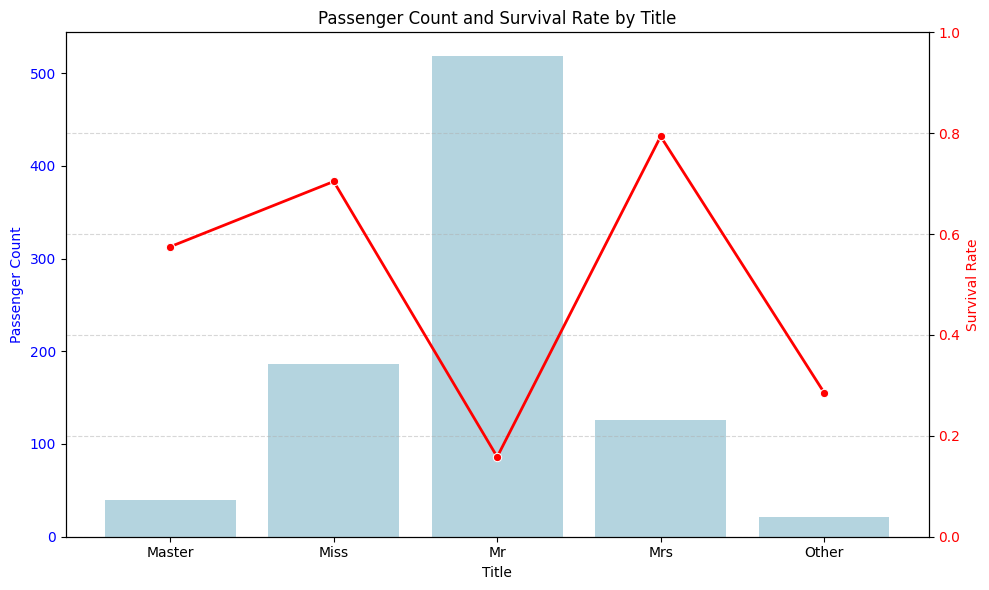

In [189]:
# Compute survival rate and count
summary = train_df.groupby('Title').agg(
    Count=('Survived', 'count'),
    Survival_Rate=('Survived', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Count
sns.barplot(data=summary, x='Title', y='Count', ax=ax1, color='lightblue')
ax1.set_ylabel('Passenger Count', color='blue')
ax1.set_xlabel('Title')
ax1.tick_params(axis='y', labelcolor='blue')

# Add survival rate on second axis
ax2 = ax1.twinx()
sns.lineplot(data=summary, x='Title', y='Survival_Rate', ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Survival Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 1)

plt.title('Passenger Count and Survival Rate by Title')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("title_survival_count.png", dpi=300)
plt.show()


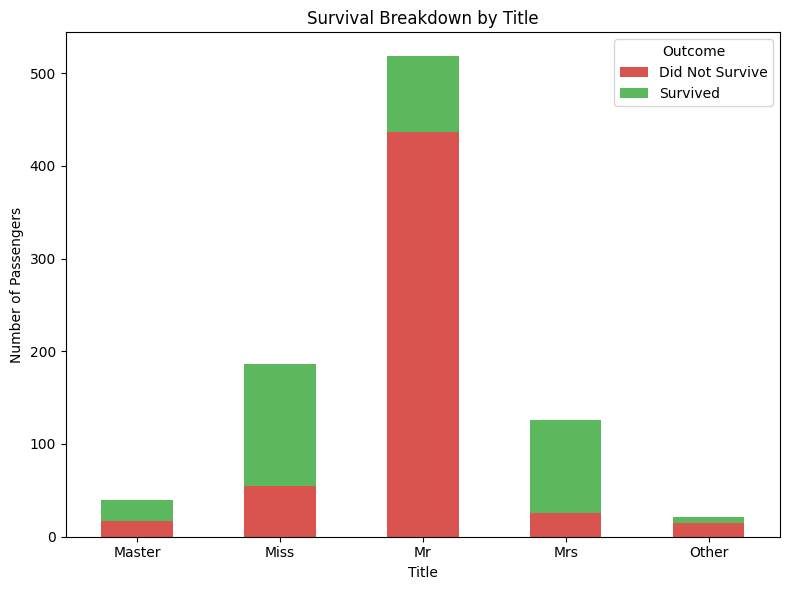

In [190]:
survival_split = train_df.groupby(['Title', 'Survived']).size().unstack().fillna(0)
survival_split.columns = ['Did Not Survive', 'Survived']
survival_split.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#d9534f', '#5cb85c'])

plt.title('Survival Breakdown by Title')
plt.ylabel('Number of Passengers')
plt.xlabel('Title')
plt.xticks(rotation=0)
plt.legend(title='Outcome')
plt.tight_layout()
plt.savefig("title_survival.png", dpi=300)
plt.show()

##### Extract Family Size

In [191]:
# SibSp = # of siblings/spouses aboard
# Parch = # of parents/children aboard
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1  # +1 includes the person themself

In [192]:
# check what's the faamily size for our data
train_df['FamilySize'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11])

In [193]:
# based on above family sizes, we can divide our family into solo, small, medium and large
train_df['FamilyCategory'] = pd.cut(train_df['FamilySize'], bins=[0,1,4,8,11], labels=['Solo', 'Small', 'Medium', 'Large'])

In [194]:
train_df['FamilyCategory'].unique()

['Small', 'Solo', 'Medium', 'Large']
Categories (4, object): ['Solo' < 'Small' < 'Medium' < 'Large']

In [195]:
# step 1: see the number of categories and their counts using groupby  
train_df.groupby('FamilyCategory', observed=False).size().reset_index(name='Count')

,FamilyCategory,Count
0,Solo,537
1,Small,292
2,Medium,55
3,Large,7


can also see that solo travellers were travelling more as compared to family 

In [196]:
# step 2: check the survival rate of each category 
train_df.groupby('FamilyCategory', observed=False)['Survived'].mean()

# note this works because of the survive = 0 and died = 0 nature of our dataset

FamilyCategory
Solo      0.303538
Small     0.578767
Medium    0.181818
Large     0.000000
Name: Survived, dtype: float64

insights

- large families didn't quite survive
- small familes (1-4) have high chances of survival
- medium families also have low survival rate

C:\Users\gupta\AppData\Local\Temp\ipykernel_11760\2164582685.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  family_stats = train_df.groupby('FamilyCategory').agg(


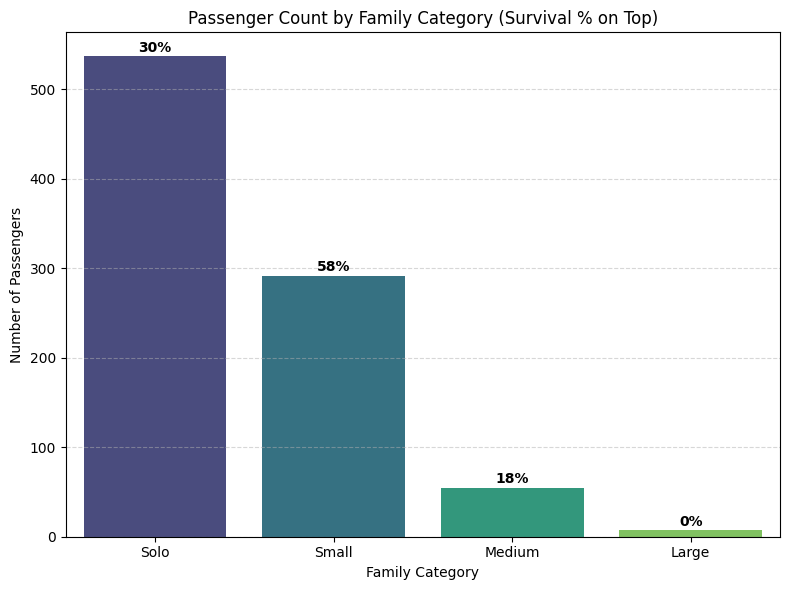

In [197]:
# Count passengers per category + survival rate
family_stats = train_df.groupby('FamilyCategory').agg(
    Passenger_Count=('Survived', 'count'),
    Survival_Rate=('Survived', 'mean')
).reset_index()

# Plot count per category
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=family_stats, x='FamilyCategory', y='Passenger_Count', palette='viridis', hue='FamilyCategory')

# Add survival rate labels on top of each bar
for i, row in family_stats.iterrows():
    ax.text(i, row['Passenger_Count'] + 2, f"{row['Survival_Rate']:.0%}", 
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Passenger Count by Family Category (Survival % on Top)')
plt.ylabel('Number of Passengers')
plt.xlabel('Family Category')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("C:/self-learn/mini_projects/week3/family_survival.png", dpi=300)
plt.show()

#### Fill Missing Values

In [198]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
# Even if multiple values are tied for the mode, .mode() returns all of them — and [0] just picks the first one. 
# It's deterministic and works fine unless you specifically care about the tie.

In [199]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

### Selection, Encoding and Preprocessing

#### Feature Selection 

In [200]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Deck', 'Title',
       'FamilySize', 'FamilyCategory'],
      dtype='object')

columns to be dropped because either they are not needed or we developed better versions of them
- PassengerId
- Name
- Sibsp
- Parch
- Ticket
- Fare
- Cabin

In [201]:
to_drop = ['Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin' ]
train_df.drop(columns=to_drop, inplace=True)

#### Encoding Categorical Variables 

In [202]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Sex             891 non-null    object  
 4   Age             891 non-null    float64 
 5   Embarked        891 non-null    object  
 6   Deck            891 non-null    object  
 7   Title           891 non-null    object  
 8   FamilySize      891 non-null    int64   
 9   FamilyCategory  891 non-null    category
dtypes: category(1), float64(1), int64(4), object(4)
memory usage: 63.8+ KB


Machine learning models can’t understand text, so you need to convert:

- Sex, Embarked, Title, Deck, FamilyCategory into numerical form.
- You can use pd.get_dummies() for one-hot encoding, or LabelEncoder if needed.

In [203]:
to_dummy = ['Sex', 'Embarked', 'Title', 'Deck', 'FamilyCategory']
train_df = pd.get_dummies(train_df, columns=to_dummy, drop_first=True)

In [204]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'FamilySize', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_T', 'Deck_U', 'FamilyCategory_Small',
       'FamilyCategory_Medium', 'FamilyCategory_Large'],
      dtype='object')

#### Preprocessing Data

In [ ]:
from titanic_preprocessor import TitanicPreprocessor
prep = TitanicPreprocessor()
train_df = pd.read_csv('data/train.csv')
train_df = prep.preprocess(train_df) # does the above feature engineering in a python file so that we don't have to repeat for the test data

In [206]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            891 non-null    int64  
 1   Survived               891 non-null    int64  
 2   Pclass                 891 non-null    int64  
 3   Age                    891 non-null    float64
 4   FamilySize             891 non-null    int64  
 5   Title_Miss             891 non-null    bool   
 6   Title_Mr               891 non-null    bool   
 7   Title_Mrs              891 non-null    bool   
 8   Title_Other            891 non-null    bool   
 9   Sex_male               891 non-null    bool   
 10  Embarked_Q             891 non-null    bool   
 11  Embarked_S             891 non-null    bool   
 12  Deck_B                 891 non-null    bool   
 13  Deck_C                 891 non-null    bool   
 14  Deck_D                 891 non-null    bool   
 15  Deck_E

In [ ]:
prep2 = TitanicPreprocessor()
test_df = pd.read_csv('data/test.csv')
test_df = prep2.preprocess(test_df)
test_df.info() # won't have 'Survived' column 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            418 non-null    int64  
 1   Pclass                 418 non-null    int64  
 2   Age                    418 non-null    float64
 3   FamilySize             418 non-null    int64  
 4   Title_Master           418 non-null    bool   
 5   Title_Miss             418 non-null    bool   
 6   Title_Mr               418 non-null    bool   
 7   Title_Mrs              418 non-null    bool   
 8   Title_Other            418 non-null    bool   
 9   Sex_male               418 non-null    bool   
 10  Embarked_Q             418 non-null    bool   
 11  Embarked_S             418 non-null    bool   
 12  Deck_B                 418 non-null    bool   
 13  Deck_C                 418 non-null    bool   
 14  Deck_D                 418 non-null    bool   
 15  Deck_E

### Base Model - Logistic Regression 

In [208]:
from sklearn.model_selection import train_test_split

train_x = train_df.drop(columns='Survived')
train_y = train_df['Survived']

In [209]:
test_df = test_df.reindex(columns=train_df.columns, fill_value=0) # to ensure that testing data has the same features that our model has trained on 

In [210]:
from sklearn.linear_model import LogisticRegression

lr  = LogisticRegression(max_iter=1000)
lr.fit(train_x, train_y)

y_pred = lr.predict(test_df[train_x.columns])
# This guarantees that your prediction data has only the exact same columns (in the same order) as your training data.

c:\self-learn\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [211]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred # y_pred is a numpy arrays consisting of 0s and 1s 
})
submission.to_csv('submission.csv', index=False)
# 77.751% on kaggle


In [212]:
# evaluate the model

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, train_x, train_y, cv=5)
print("CV Accuracy: ", scores.mean())
# CV Accuracy:  0.8271608813006089

c:\self-learn\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\self-learn\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

CV Accuracy:  0.8271608813006089


c:\self-learn\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Improving

#### Scaling and Converging 

we got a bunch of warnings while calculating the CV score. the warning means that the optimization algorithm (default:lbfgs) hit the max number of iteration (1000) before the loss function fully converged 

solutions:
1. standardize input features because many ml models (especially logistic regression) perform better and converge faster when featuires are scaled to a similar range - normalization 
2. increase max iterations (especially when you're just starting out) but this just delays the problem, scaling is the better fix 
3. if for some reason lbfgs continue to fail even after scaling, use `saga` or `liblinear`

+ the attached passenger id may be casuing trouble, we can attach it later, after the fitting and prediction (it may cause issue because of it having a much bigger range than age or family size)


In [213]:
#1. Drop passenger id (not from the main dataframe)

# train_x is the processed train_df with the 'survived' column dropped
# train_x_model is the train_x with 'passengerID' dropped 
# made a copy so as to not lose passenger id from the original train_x 

train_x_model  = train_x.drop(columns=['PassengerId'])
train_y = train_df['Survived']

# test _df is also processed containing passengerID and has no 'survived' column
test_x_model = test_df[train_x_model.columns]
# to make sure testing has same columns as training

In [214]:
#2. Fit and Predict 

# boolean values will be treated as 0 and 1 so no issue in scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
model  = LogisticRegression(C=0.1, max_iter=1000)
# C is regularization strength - preventing model from learning patterns that are too specific to training data
# lower c = more regularization 
# higher c = less regularization (model fits training data more), which we don't want 
# this is hyperparamter tuning

train_x_scaled = scaler.fit_transform(train_x_model)
test_x_scaled = scaler.transform(test_x_model)

model.fit(train_x_scaled, train_y)

y_pred = model.predict(test_x_scaled)

In [215]:
#3. Check the CV score now 

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, train_x_scaled, train_y, cv=5)
print("CV Accuracy: ", scores.mean())

CV Accuracy:  0.8294143493817085


scaling (a type of normalization) didn't really impact the accuracy score because:
- scaling helps optimization, meaning helping the loss function to converge (which it did)
- scaling prevents convergence issues but won't necessarily increase accuracy 

you can easily see above that the previous warning of not converging in 1000 iterations has been fixed, meaning, the loss function did converge and we did not have to increase the number of iterations, so yay!

more about cv=5:
- Split the training data into 5 equal-sized folds (or as equal as possible)
- For each iteration, use 4 folds for training and 1 remaining fold for validation
- Repeat this process in total 5 times, so that each fold serves as the validation set exactly once 
- Record the accuracy (or whatever metric you choose) for each run
- Take the mean of these 5 scores to get the overall cross-validated accuracy

cross validation is a better estimate of your model’s performance than a single train-test split, because:
- It reduces the impact of chance (e.g., unlucky splits)
- It shows how stable your model is across different data slices

#### Decision Tree

In [216]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(train_x_scaled, train_y)

# Evealute using cross-validation
scores = cross_val_score(dt_model, train_x_scaled, train_y, cv=5)
print("CV Accuracy (Decision Tree): ", scores.mean()) 

CV Accuracy (Decision Tree):  0.7991274872889336


#### Random Forest 

In [217]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_x_scaled, train_y)

# Evaluate using cross-validation
scores = cross_val_score(rf, train_x_scaled, train_y, cv=5)
print("CV Accuracy (Random Forest): ", scores.mean())

CV Accuracy (Random Forest):  0.8047266336074321


#### Gradient Boosting (XGBoost)

In [218]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

xg = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xg.fit(train_x_scaled, train_y)

# Evaluate using cross-validation
scores = cross_val_score(xg, train_x_scaled, train_y, cv=5)
print("CV Accuracy (XGBoost): ", scores.mean())


CV Accuracy (XGBoost):  0.815956311593748


#### Ensemble Methods (Stacking)

In [219]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

logreg = LogisticRegression(max_iter=1000, C=0.5)
rf = RandomForestClassifier(n_estimators=100)
xg = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

ensemble = VotingClassifier(estimators=[('logreg', logreg), ('rf', rf), ('xg', xg)], voting='soft')
ensemble.fit(train_x_scaled, train_y)

# Evaluate using cross-validation
scores = cross_val_score(ensemble, train_x_scaled, train_y, cv=5)
print("CV Accuracy (Ensemble): ", scores.mean())


CV Accuracy (Ensemble):  0.8271671583704727


#### Stratified K-Fold Evaluation

In [220]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(LogisticRegression(max_iter=1000), train_x_scaled, train_y, cv=stratified_kfold)
print("CV Accuracy (StratifiedKFold): ", scores.mean())


CV Accuracy (StratifiedKFold):  0.8305128366078713


#### RF with GridSearch CV 

In [221]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, random_state=42, cv=5)
random_search.fit(train_x_scaled, train_y)
print("Best Random Forest Parameters: ", random_search.best_params_)


Best Random Forest Parameters:  {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}


In [222]:
best_rf = random_search.best_estimator_
# best estimators gives you the actual trained RandomForestClassifier with the best combo of hyperparamters found during the search

scores = cross_val_score(best_rf, train_x_scaled, train_y, cv=5)

print("Manual CV Accuracy (best model):", scores.mean())
print("All fold scores:", scores)


Manual CV Accuracy (best model): 0.8316678174628084
All fold scores: [0.81564246 0.82022472 0.85955056 0.80337079 0.85955056]


In [223]:
#4. Create a submission file with passengerID
y_pred = best_rf.predict(test_x_scaled)

submission2 = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred
})

submission2.to_csv('submission2.csv', index=False)


highest score achived using rf with grid search cv - 78.46 on kaggle 

### Conclusion

**Logistic regression is surprisingly strong for Titanic (77.75%)**
* Since the dataset has strong linearly separable features like Sex, Pclass, Title, and FamilySize, which Logistic Regression handles well.
* scaling, encoding, and feature engineering are clearly working.